In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf

tf.random.set_seed(42)

import keras
from keras import layers
import os
import glob
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 16
EPOCHS = 20

12727482/12727482 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


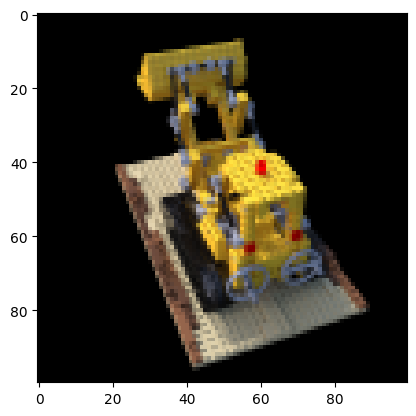

In [ ]:
url = (
    "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
)
data = keras.utils.get_file(origin=url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

In [ ]:
def encode_position(x):
    """
    Codifica a posição em seu recurso de Fourier correspondente.

    Argumentos:
        x: A coordenada de entrada.

    Retorna:
        Fourier apresenta tensores de posição.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0**i * x))
    return tf.concat(positions, axis=-1)

def get_rays(height, width, focal, pose):
    """
    Calcula o ponto de origem e o vetor de direção dos raios.

    Argumentos:
        altura: Altura da imagem.
        largura: Largura da imagem.
        focal: A distância focal entre as imagens e a câmera.
        pose: A matriz de pose da câmera.

    Retorna:
        Tupla de ponto de origem e vetor de direção para raios.
    """
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )
    transformed_i = (i - width * 0.5) / focal
    transformed_j = (j - height * 0.5) / focal
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    return (ray_origins, ray_directions)

def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """
    Renderiza os raios e os achata.

    Argumentos:
        ray_origins: os pontos de origem dos raios.
        ray_directions: Os vetores unitários de direção dos raios.
        perto: O limite próximo da cena volumétrica.
        longe: O limite distante da cena volumétrica.
        num_samples: Número de pontos de amostra em um raio.
        rand: Escolha para randomizar a estratégia de amostragem.

    Retorna:
       Tupla de raios achatados e pontos de amostra em cada raio.
       """
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)

def map_fn(pose):
    """Mapeia a pose individual para raios achatados e pontos de amostra.

    Argumentos:
        pose: A matriz de pose da câmera.

    Retorna:
        Tupla de raios achatados e pontos de amostra correspondentes ao
        pose de câmera.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)


split_index = int(num_images * 0.8)

train_images = images[:split_index]
val_images = images[split_index:]

train_poses = poses[:split_index]
val_poses = poses[split_index:]

train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [ ]:
def get_nerf_model(num_layers, num_pos):
    """
    Gera a rede neural NeRF.

    Argumentos:
        num_layers: O número de camadas MLP.
        num_pos: o número de dimensões da codificação posicional.

    Retorna:
        O modelo `keras`.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """
    Gera a imagem RGB e o mapa de profundidade a partir da previsão do modelo.

    Argumentos:
        modelo: O modelo MLP que é treinado para prever o rgb e
            densidade de volume da cena volumétrica.
        rays_flat: Os raios achatados que servem como entrada para
            o modelo NeRF.
        t_vals: Os pontos de amostra para os raios.
        rand: Escolha para randomizar a estratégia de amostragem.
        treinar: se o modelo está em fase de treinamento ou teste.

    Retorna:
        Tupla de imagem RGB e mapa de profundidade.
    """
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    delta = t_vals[..., 1:] - t_vals[..., :-1]
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return(rgb, depth_map)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


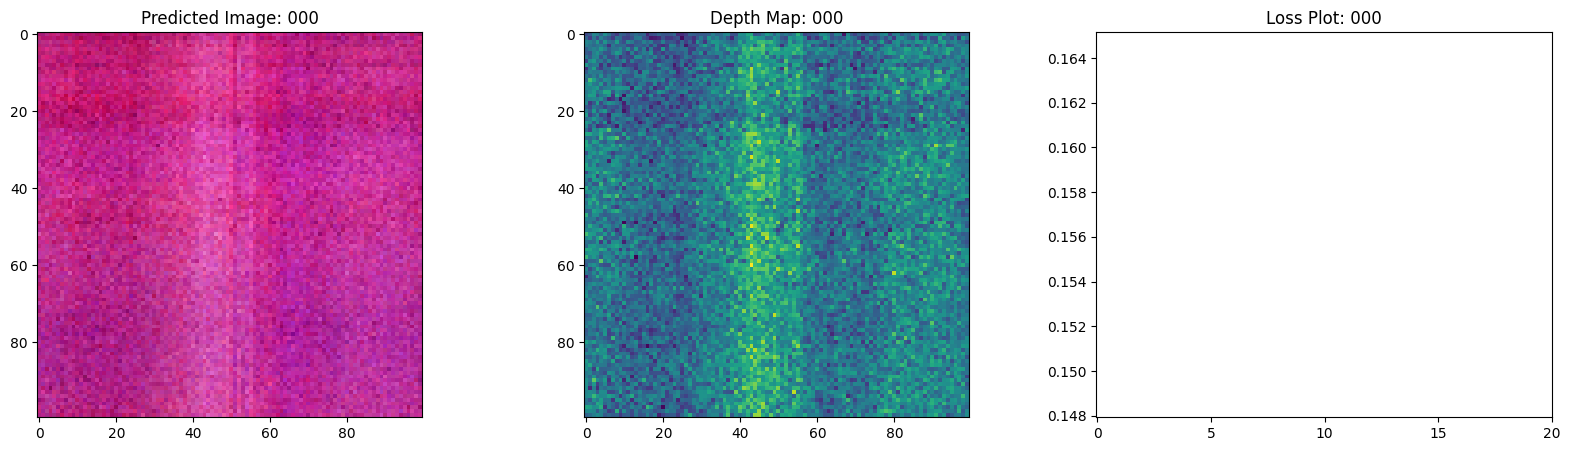

16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.1939 - psnr: 7.2489 - val_loss: 0.0836 - val_psnr: 10.9198
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


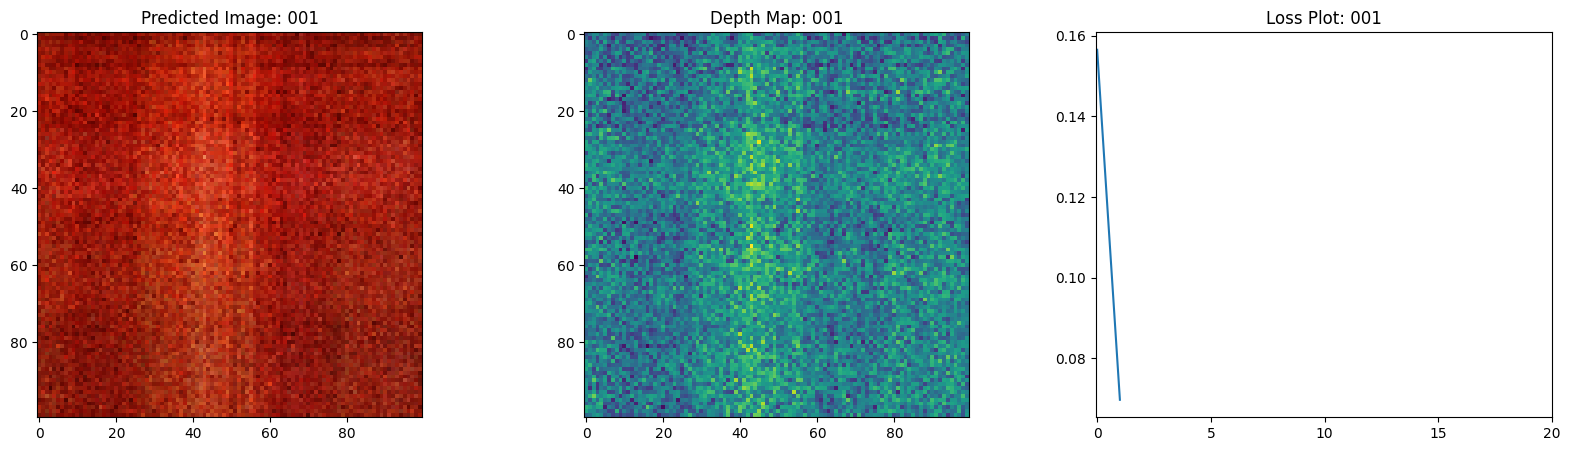

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0686 - psnr: 11.9812 - val_loss: 0.0713 - val_psnr: 11.8778
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


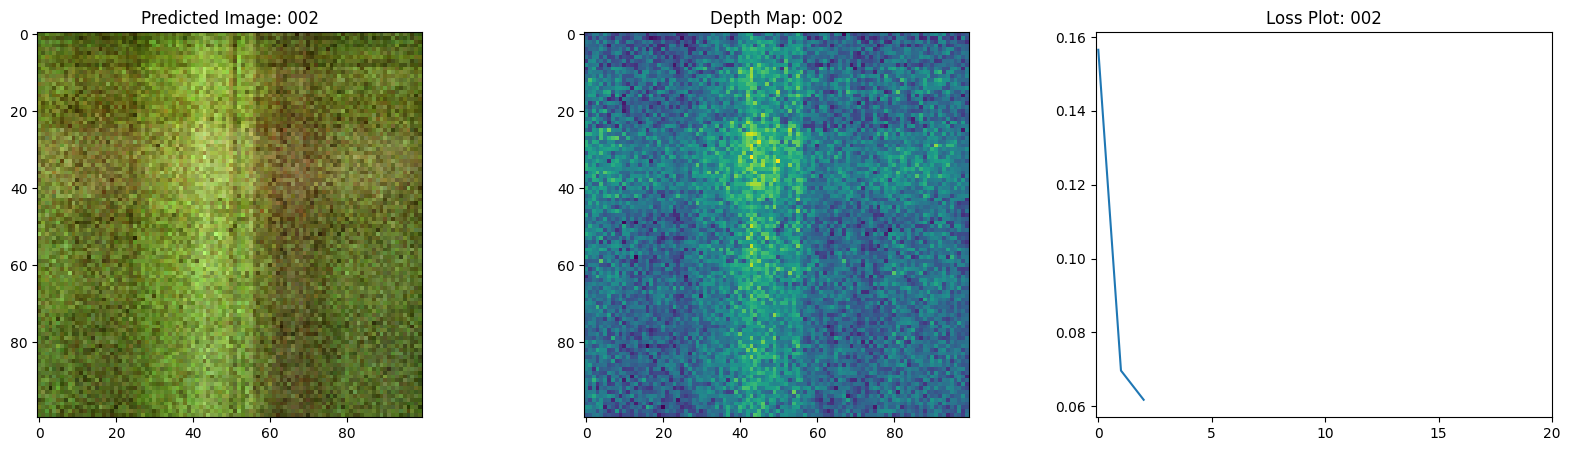

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0624 - psnr: 12.3975 - val_loss: 0.0652 - val_psnr: 12.2379
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


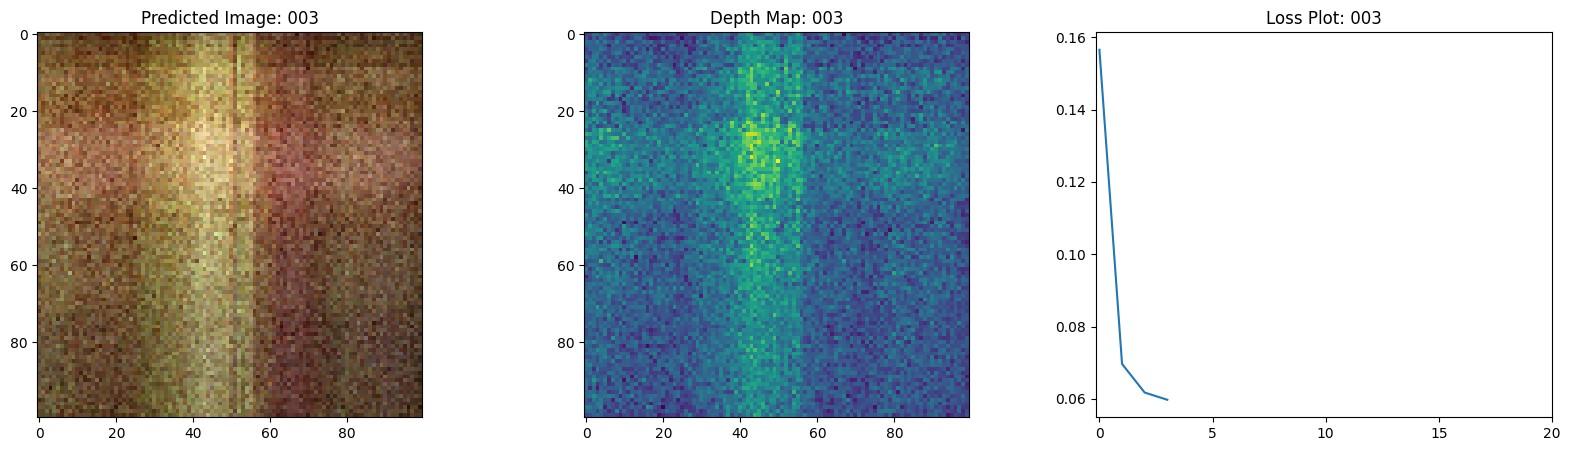

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0588 - psnr: 12.6976 - val_loss: 0.0639 - val_psnr: 12.3350
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


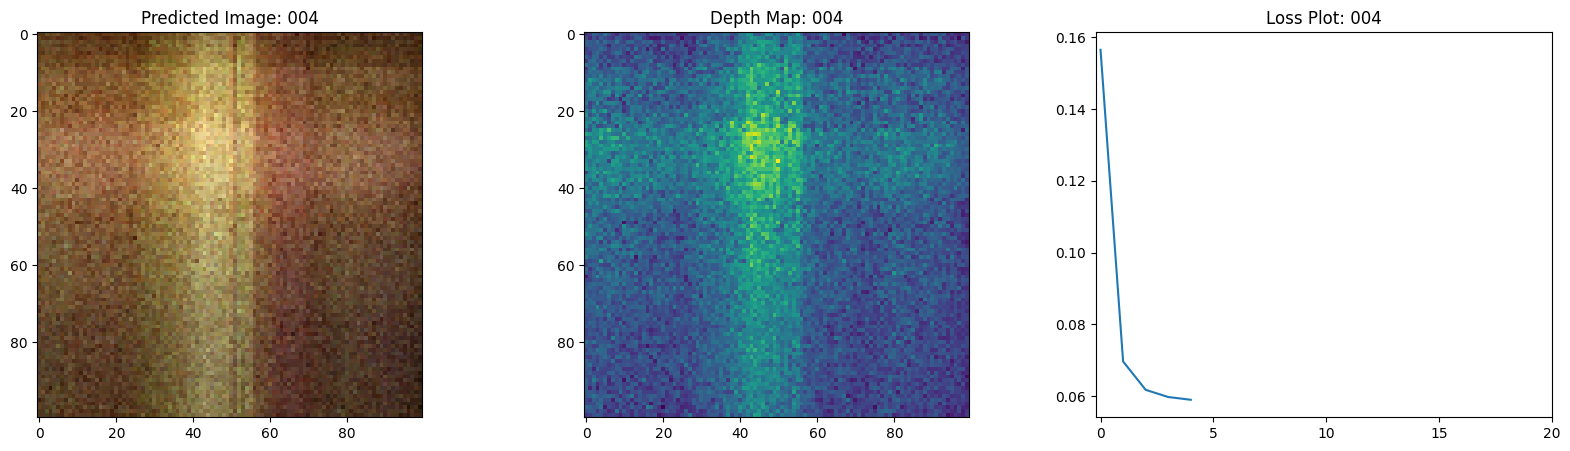

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0571 - psnr: 12.8110 - val_loss: 0.0636 - val_psnr: 12.3591
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


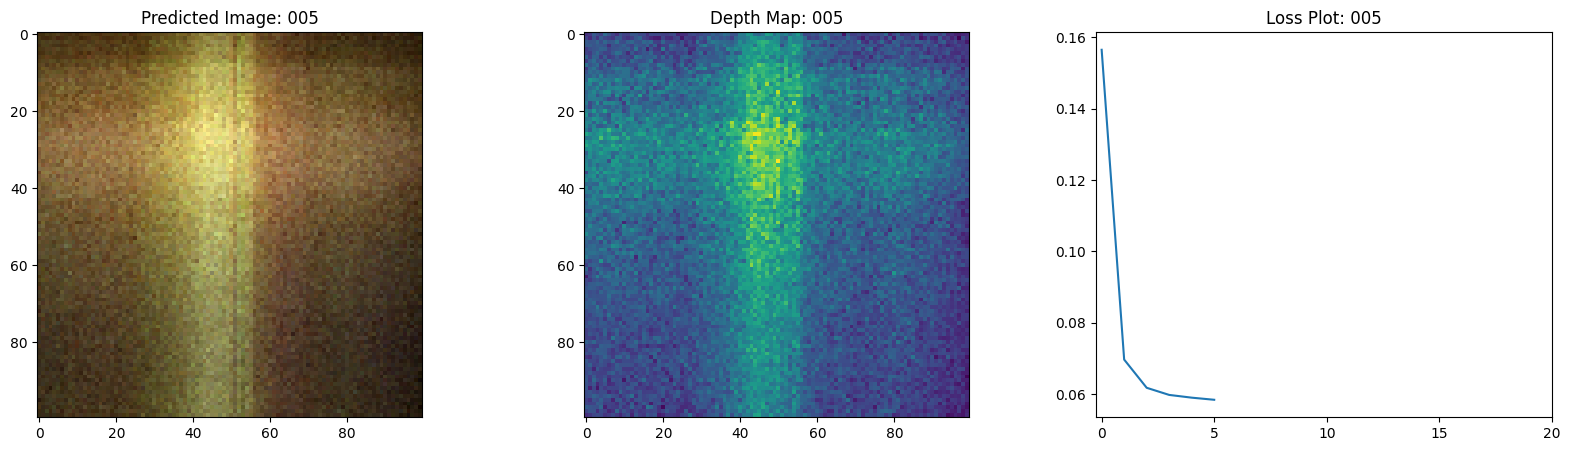

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0578 - psnr: 12.7539 - val_loss: 0.0635 - val_psnr: 12.2550
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


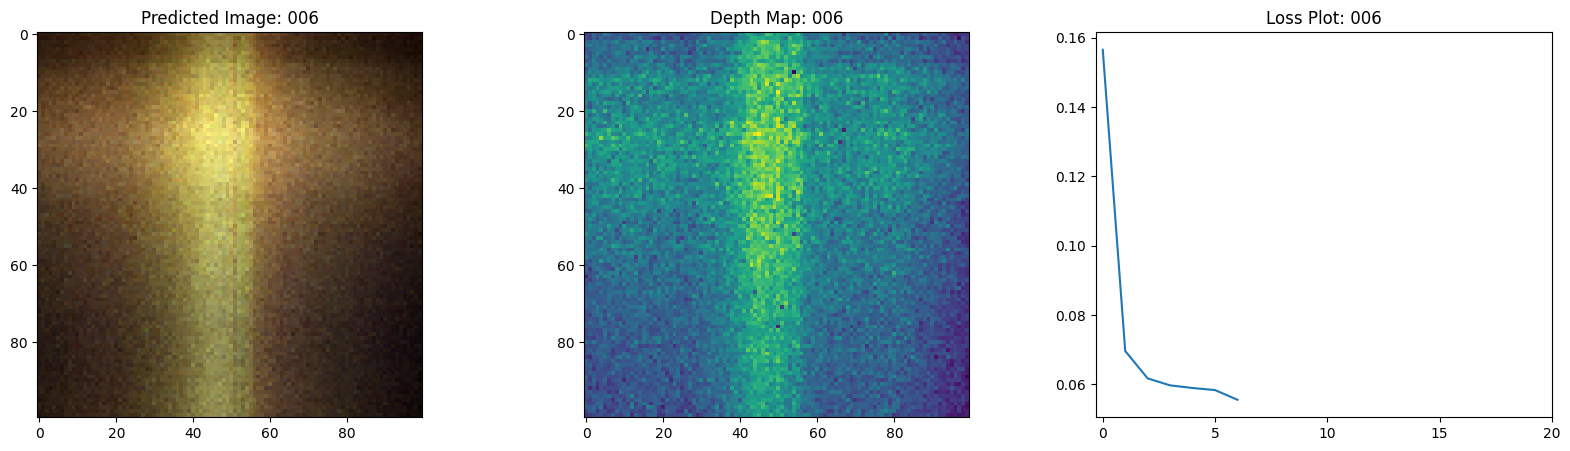

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0545 - psnr: 13.0010 - val_loss: 0.0595 - val_psnr: 12.6016
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


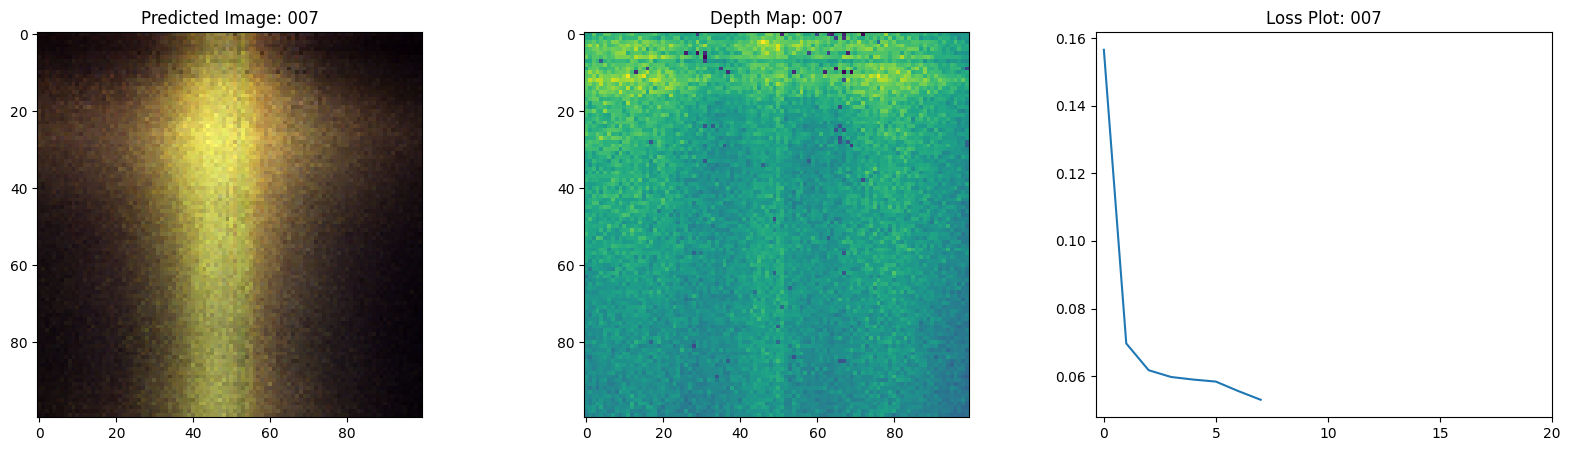

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0525 - psnr: 13.1617 - val_loss: 0.0528 - val_psnr: 13.1149
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


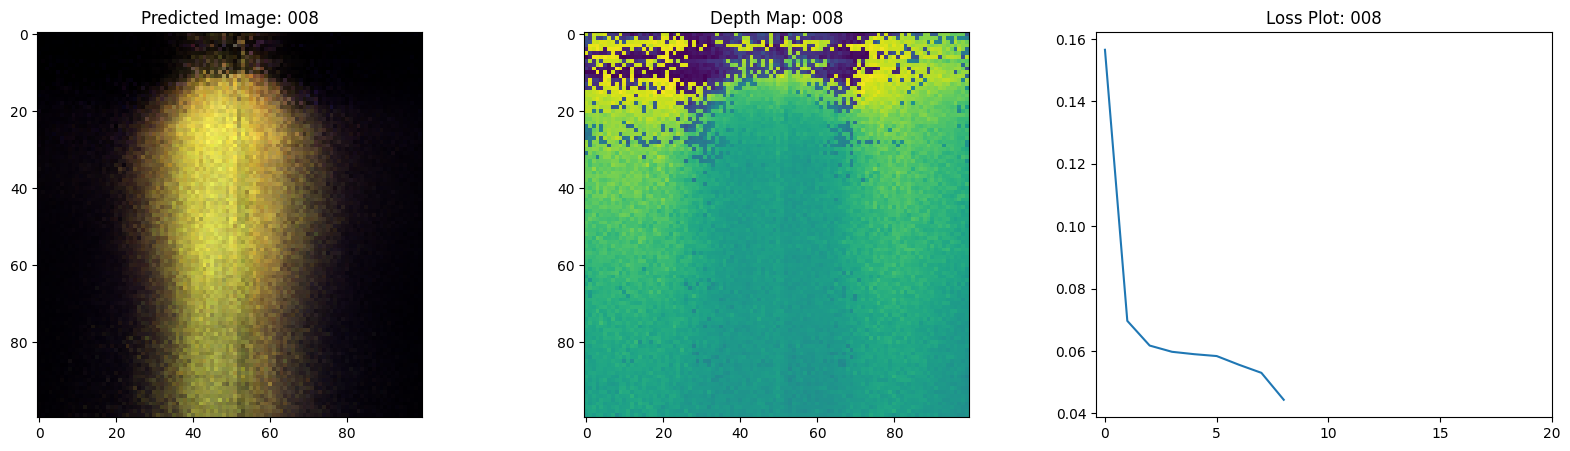

16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0461 - psnr: 13.7227 - val_loss: 0.0391 - val_psnr: 14.3520
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


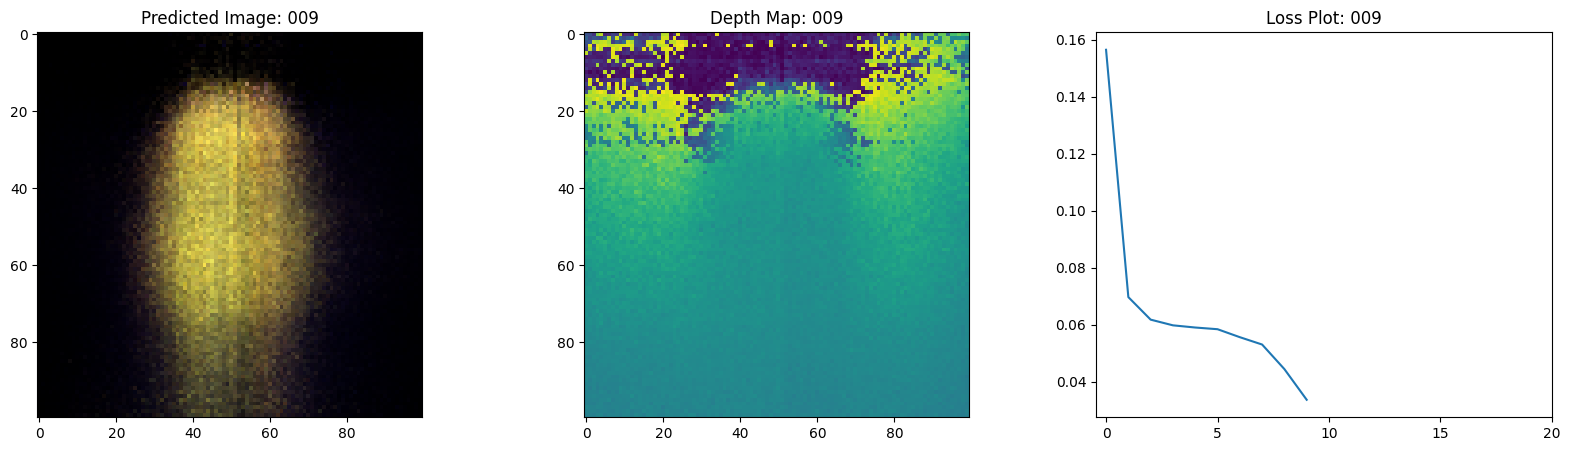

16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - loss: 0.0354 - psnr: 14.8150 - val_loss: 0.0310 - val_psnr: 15.3289
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


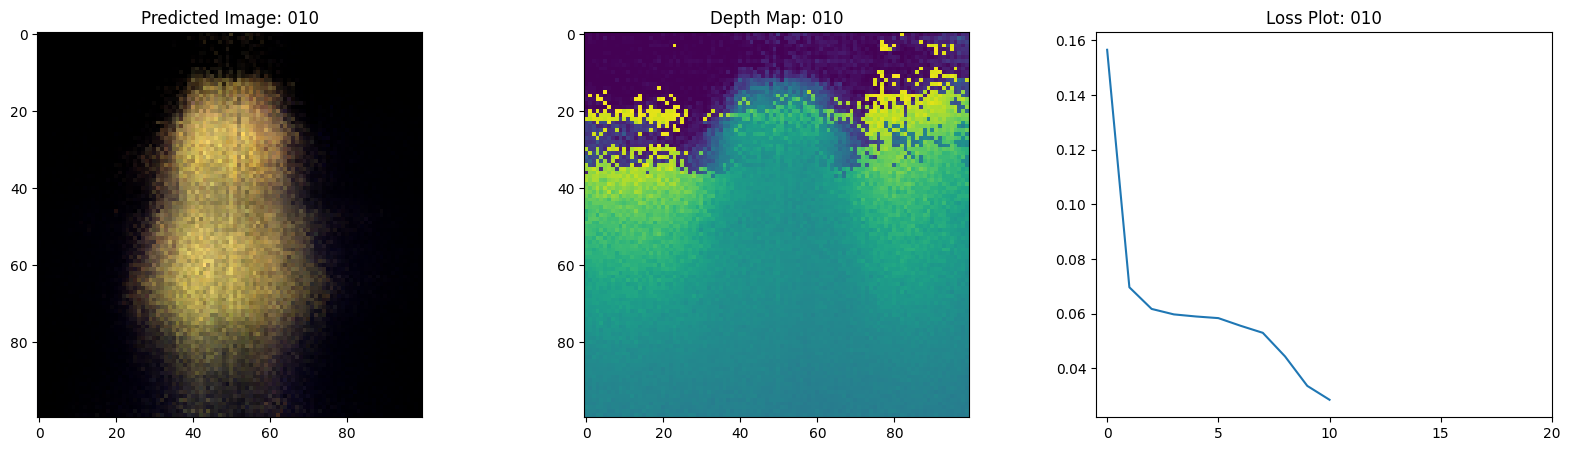

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0292 - psnr: 15.5818 - val_loss: 0.0273 - val_psnr: 15.8515
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


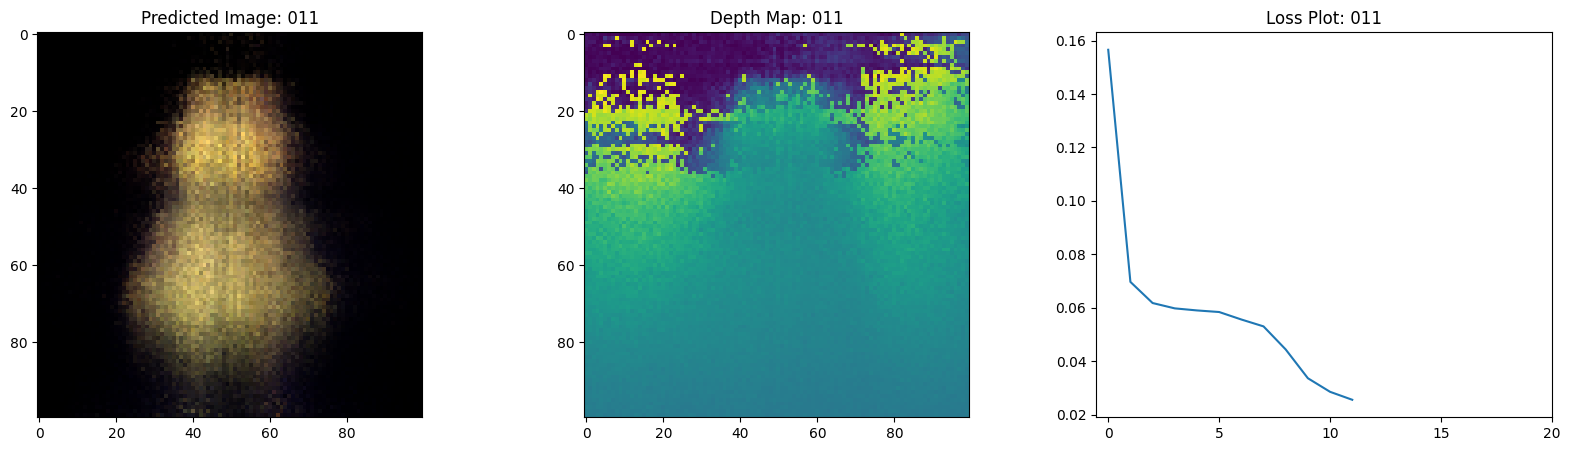

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0261 - psnr: 16.0458 - val_loss: 0.0250 - val_psnr: 16.1970
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


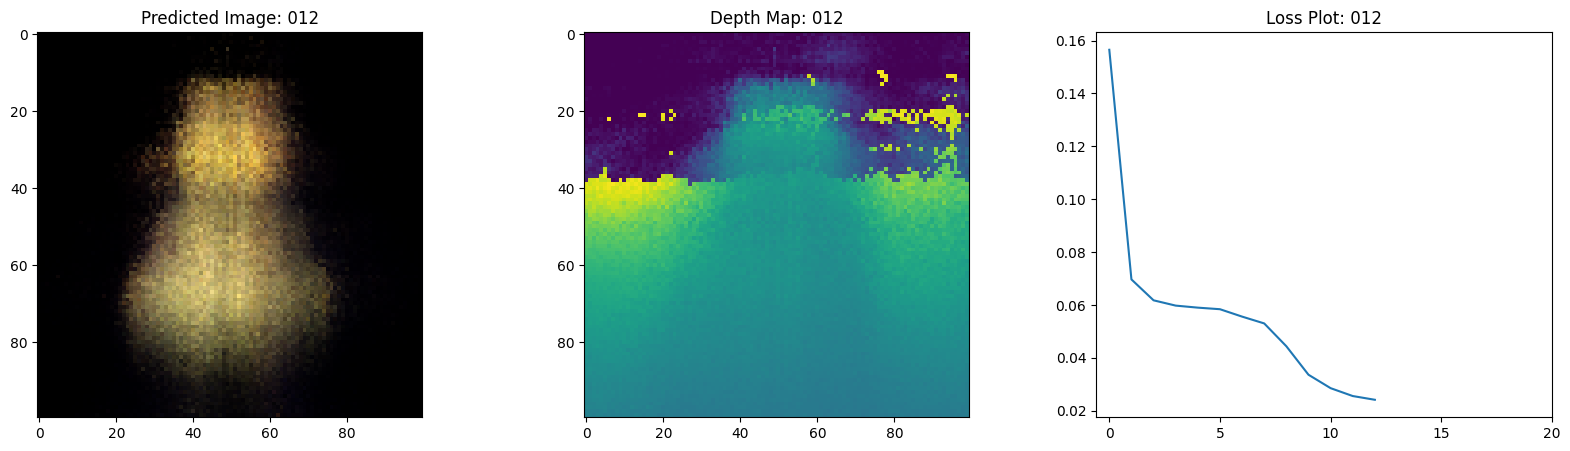

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0244 - psnr: 16.3332 - val_loss: 0.0239 - val_psnr: 16.3791
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


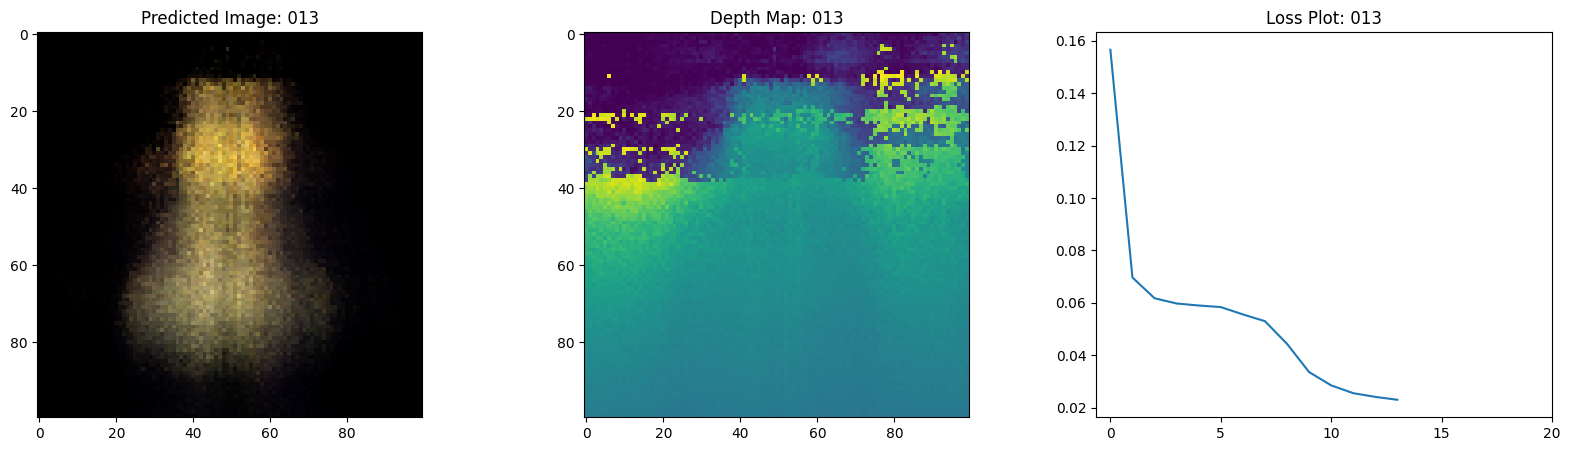

16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0242 - psnr: 16.3473 - val_loss: 0.0221 - val_psnr: 16.6415
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


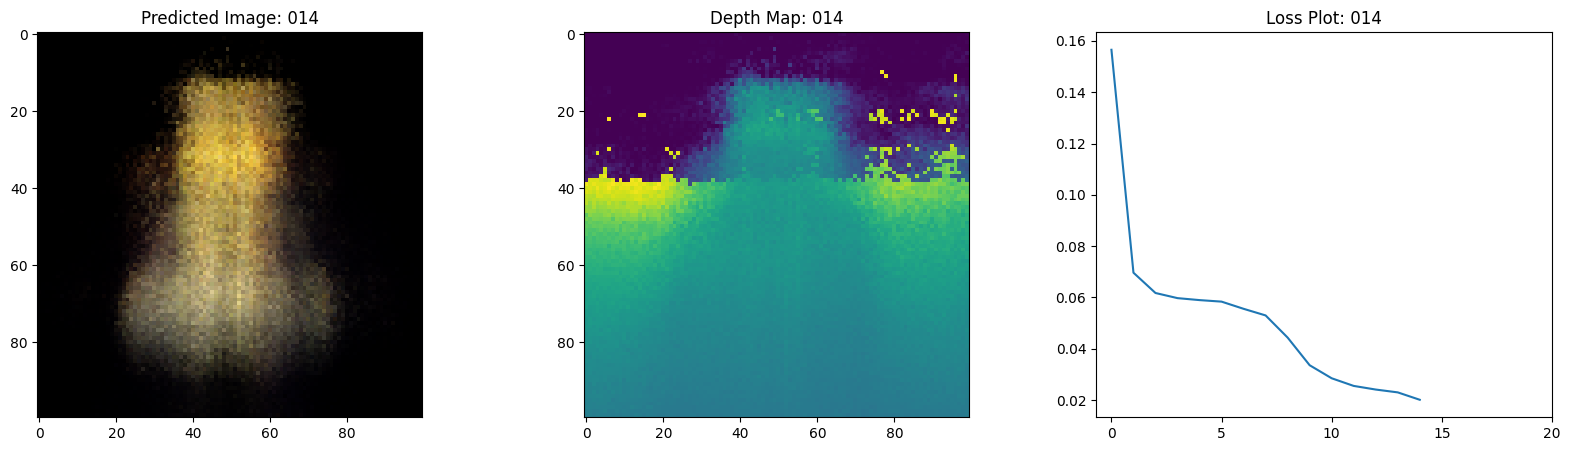

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0209 - psnr: 16.9932 - val_loss: 0.0198 - val_psnr: 17.1023
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


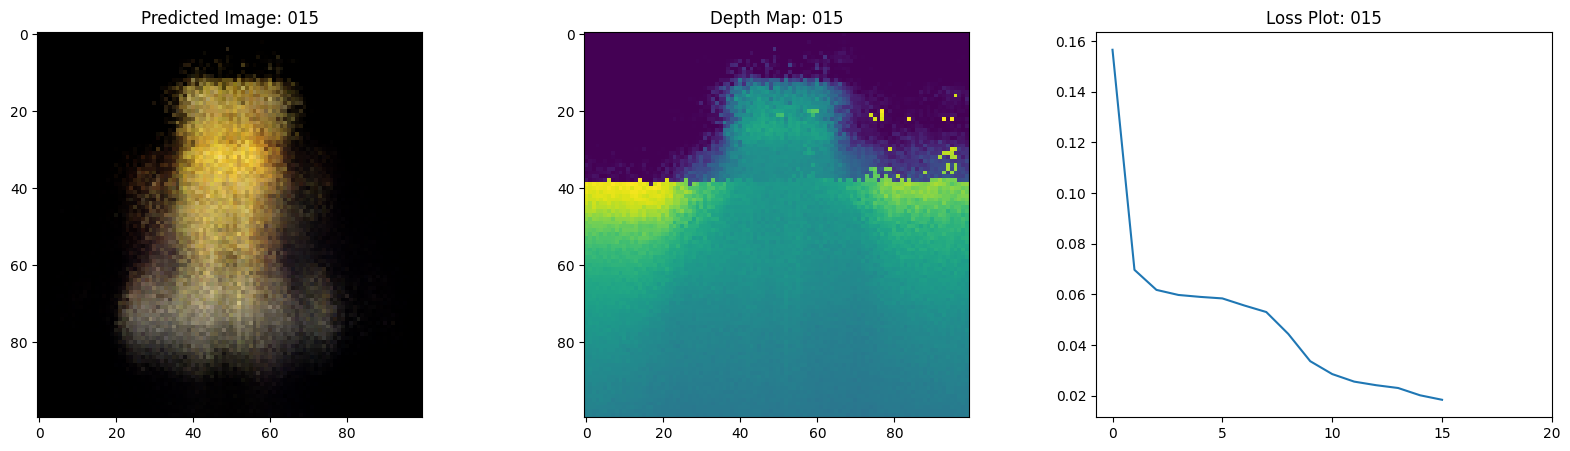

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0189 - psnr: 17.3974 - val_loss: 0.0172 - val_psnr: 17.7231
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


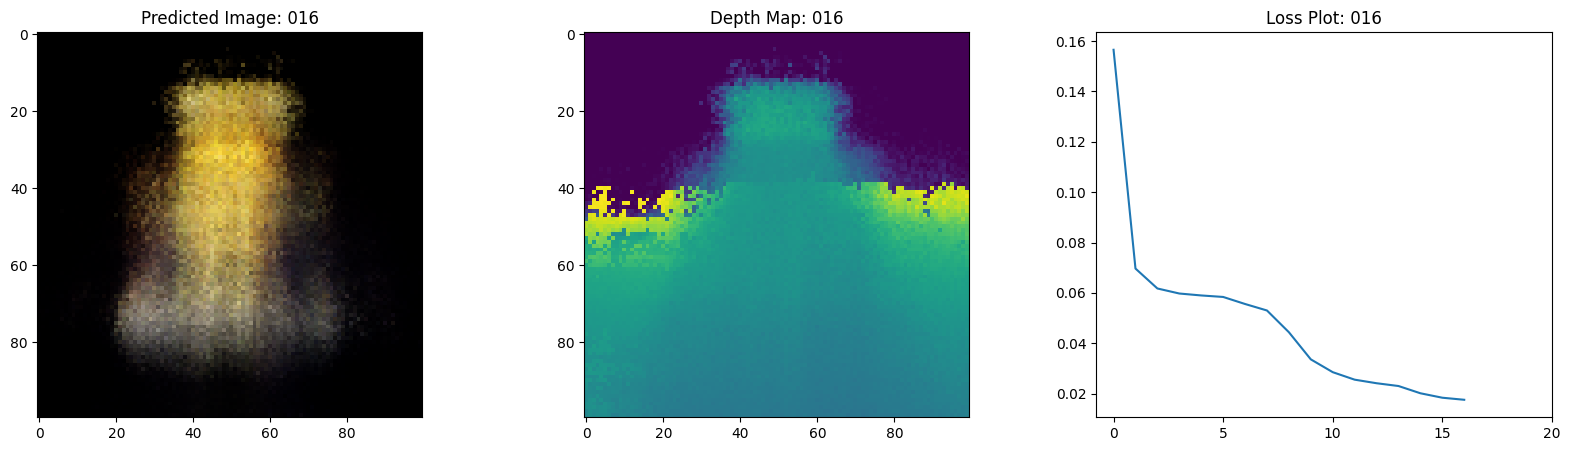

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0178 - psnr: 17.6152 - val_loss: 0.0177 - val_psnr: 17.5746
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


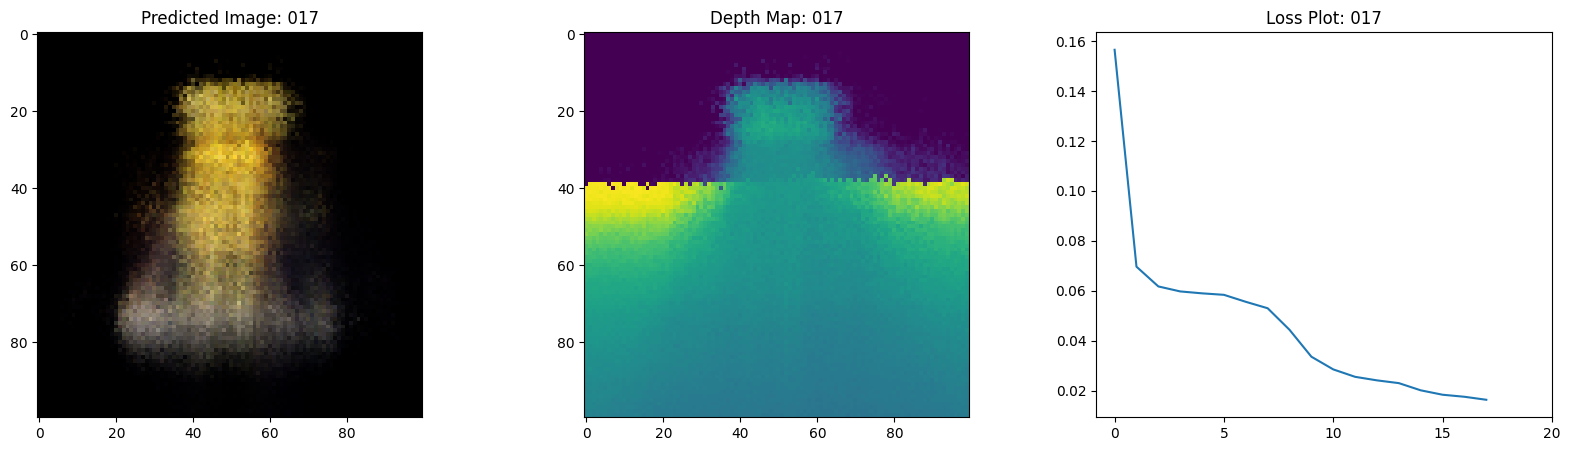

16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0167 - psnr: 17.9047 - val_loss: 0.0145 - val_psnr: 18.4813
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


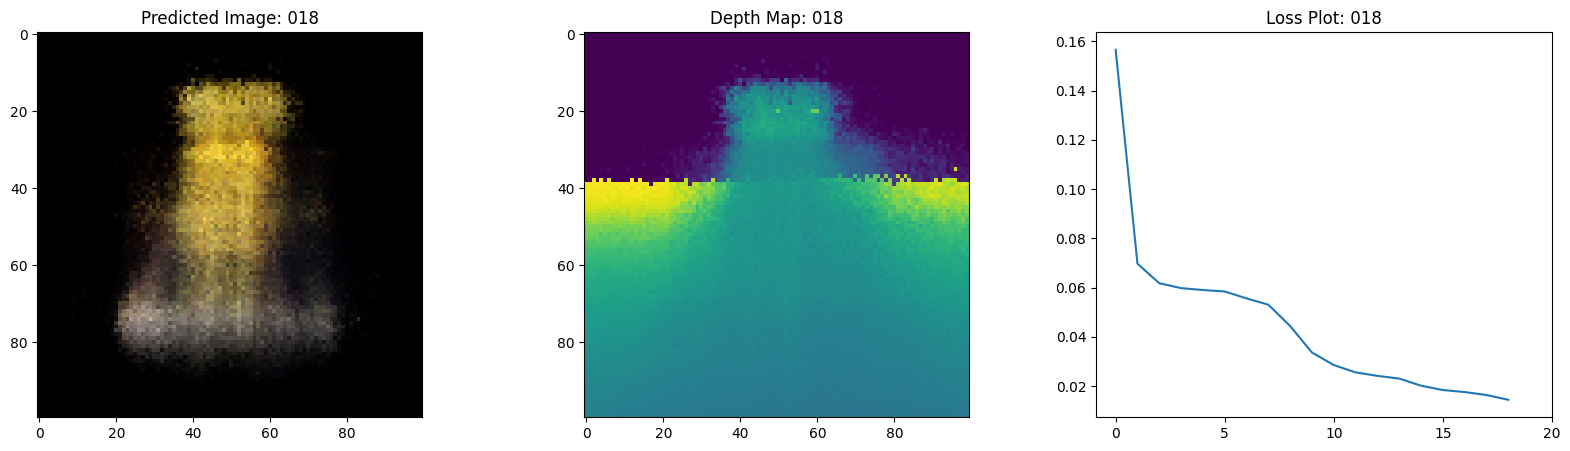

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0145 - psnr: 18.5366 - val_loss: 0.0145 - val_psnr: 18.4624
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


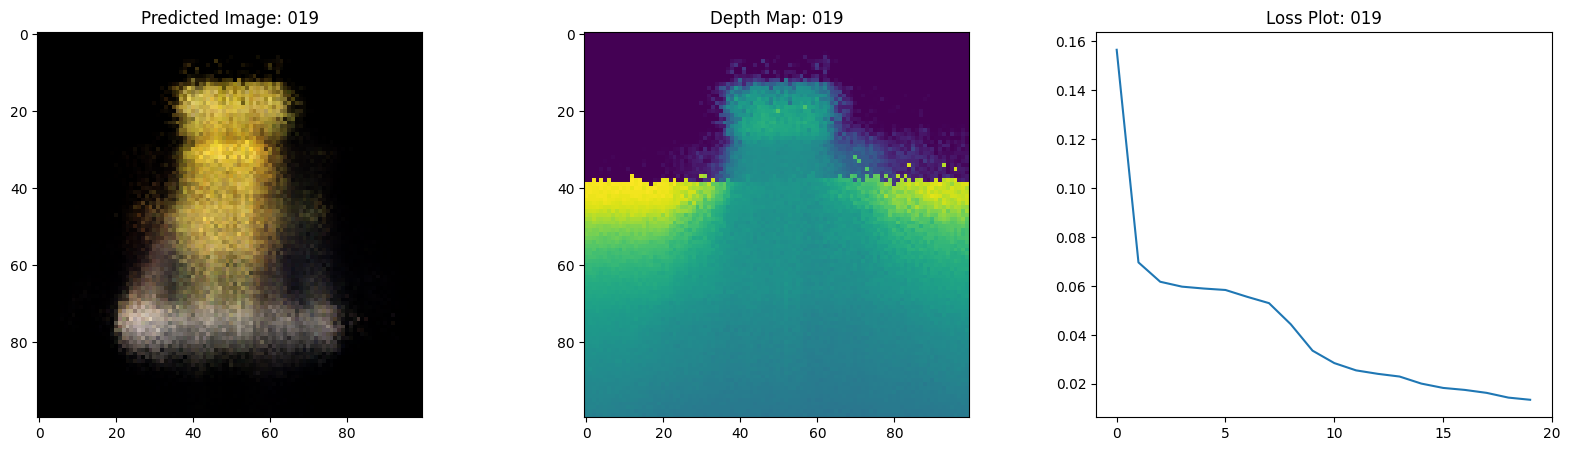

16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0135 - psnr: 18.8523 - val_loss: 0.0138 - val_psnr: 18.6909


100%|██████████| 20/20 [00:00<00:00, 47.51it/s]


In [ ]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        trainable_variables = self.nerf_model.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        psnr = tf.image.psnr(images, rgb, max_val=1.0)
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
            (images, rays) = inputs
            (rays_flat, t_vals) = rays

            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

            psnr = tf.image.psnr(images, rgb, max_val=1.0)

            self.loss_tracker.update_state(loss)
            self.psnr_metric.update_state(psnr)
            return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}
    @property
    def metrics(self):
        return[self.loss_tracker, self.psnr_metric]

test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []

class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()

num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

if not os.path.exists("images"):
    os.makedirs("images")

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
)


def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)


create_gif("images/*.png", "training.gif")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


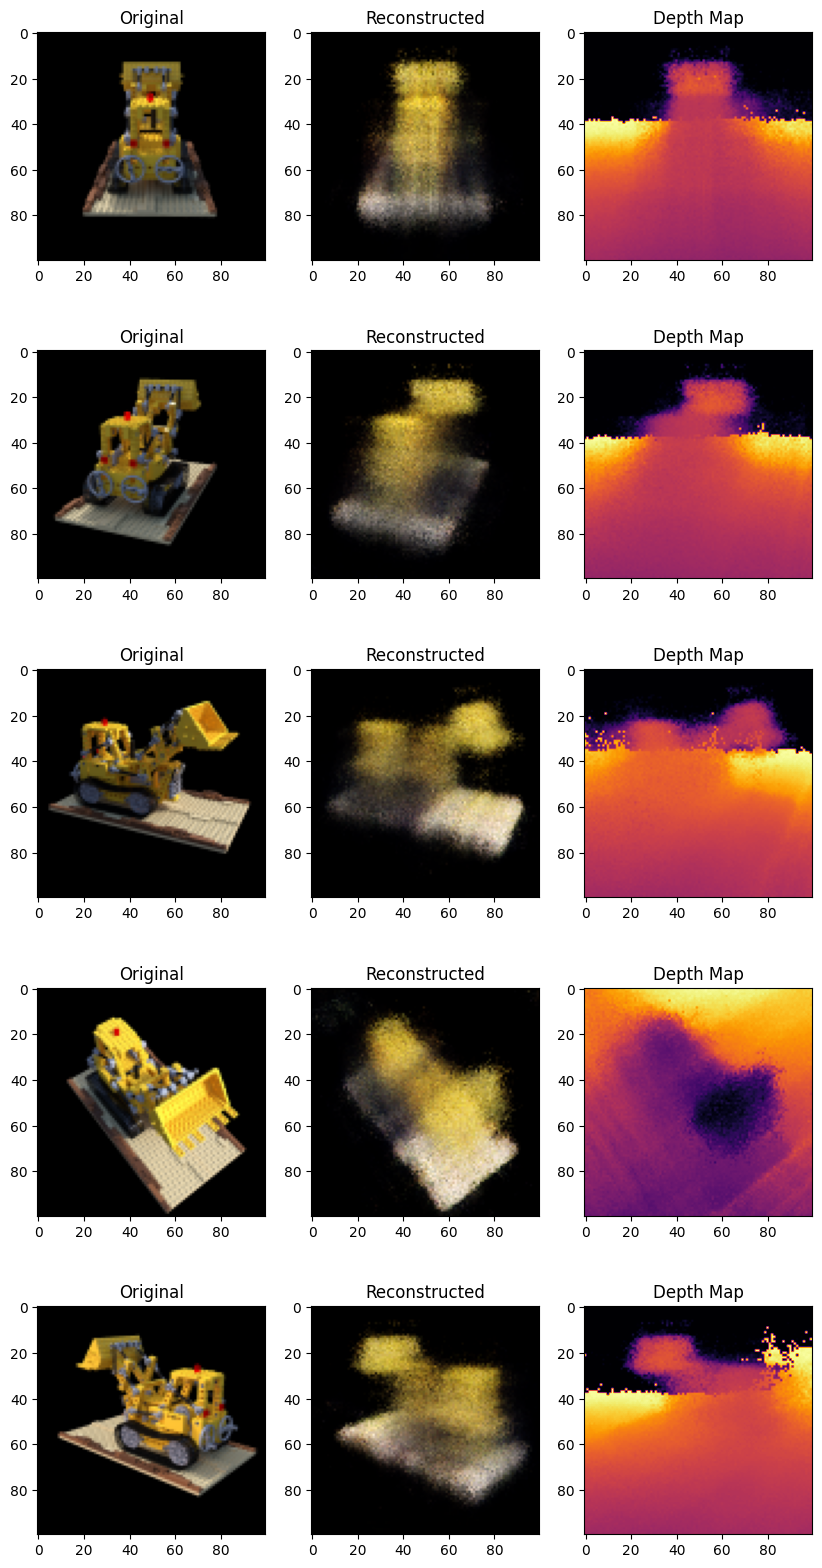

In [ ]:
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(keras.utils.array_to_img(depth_map[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")

In [ ]:
def get_translation_t(t):
    """Obtenha a matriz de tradução para movimento em t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Obtenha a matriz de rotação para movimento em phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Obtenha a matriz de rotação para movimento em teta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Leve a câmera para a matriz mundial para o theta, phi correspondente
e t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


rgb_frames = []
batch_flat = []
batch_t = []

for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    c2w = pose_spherical(theta, -30.0, 4.0)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)


1it [00:01,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


6it [00:02,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


11it [00:03,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


16it [00:05,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


21it [00:07,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


26it [00:09,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


31it [00:10,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


36it [00:12,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


41it [00:13,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


46it [00:14,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


51it [00:16,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


56it [00:18,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


65it [00:20,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


67it [00:21,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


71it [00:23,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


76it [00:24,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


81it [00:25,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


86it [00:27,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


91it [00:28,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


96it [00:29,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


105it [00:32,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


107it [00:34,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


111it [00:35,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


120it [00:36,  3.25it/s]
